In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import tree
from sklearn.metrics import mean_squared_error
from math import sqrt
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

def rmse(actual, predict):
    return sqrt(mean_squared_error(actual, predict))

def rmsle(y, y_pred):
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y + 1)).mean())

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def reject_outliers_2(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/(mdev if mdev else 1.)
    return data[s<m]

In [2]:
raw_data = pd.read_csv("train.csv")

In [3]:
raw_data['pickup_datetime'],raw_data['dropoff_datetime'] = pd.to_datetime(raw_data['pickup_datetime']),pd.to_datetime(raw_data['dropoff_datetime'])

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [5]:
raw_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


(array([  3.30000000e+01,   0.00000000e+00,   1.77000000e+02,
          0.00000000e+00,   3.18000000e+02,   0.00000000e+00,
          3.17000000e+02,   2.84000000e+02,   1.92000000e+02,
          2.18000000e+02,   2.06000000e+02,   4.21000000e+02,
          1.64000000e+02,   3.14000000e+02,   4.50000000e+02,
          2.77000000e+02,   5.24000000e+02,   4.02000000e+02,
          4.85000000e+02,   6.11000000e+02,   5.53000000e+02,
          8.32000000e+02,   9.16000000e+02,   1.43000000e+03,
          1.69300000e+03,   2.84800000e+03,   4.24500000e+03,
          6.00800000e+03,   8.77800000e+03,   1.29630000e+04,
          1.89590000e+04,   2.64870000e+04,   3.55110000e+04,
          4.50130000e+04,   5.88140000e+04,   6.89740000e+04,
          8.24950000e+04,   9.34350000e+04,   1.03080000e+05,
          1.11102000e+05,   1.12725000e+05,   1.12528000e+05,
          1.07650000e+05,   9.74220000e+04,   8.52740000e+04,
          7.07090000e+04,   5.56630000e+04,   4.15460000e+04,
        

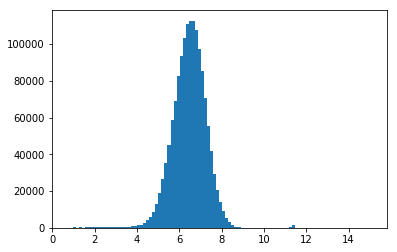

In [6]:
plt.hist(np.log(raw_data['trip_duration'] + 1), bins=100)

In [7]:
def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'

In [8]:
# format data to month
raw_data['pickup_Month'] = raw_data['pickup_datetime'].map(lambda x: x.month)
raw_data['dropoff_Month'] = raw_data['dropoff_datetime'].map(lambda x: x.month)
raw_data['pickup_Hour'] = raw_data['pickup_datetime'].map(lambda x: x.hour)
raw_data['dropoff_Hour'] = raw_data['dropoff_datetime'].map(lambda x: x.hour)

In [9]:
raw_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,3,17,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,11,12
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,4,19,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,3,13,13


In [10]:
raw_data['pickup_season'] = raw_data['pickup_Month'].apply(get_season)
raw_data['dropoff_season'] = raw_data['dropoff_Month'].apply(get_season)

(array([ 756326.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,  234370.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

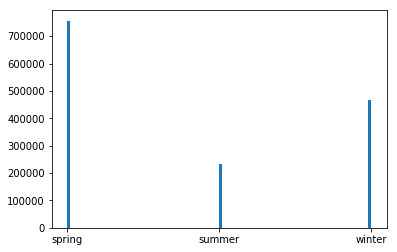

In [11]:
plt.hist(raw_data['dropoff_season'], bins=100)

In [12]:
sep_mon = pd.DataFrame(raw_data["pickup_datetime"].dt.month.values, columns=["Month"])
sep_mon["Passenger"] = raw_data["passenger_count"].copy()

In [13]:
sep_mon.head()

,Month,Passenger
0,3,1
1,6,1
2,1,1
3,4,1
4,3,1


In [14]:
aggr_sum_mon = sep_mon.groupby("Month").sum()

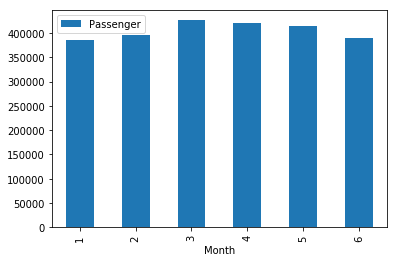

In [15]:
aggr_sum_mon.plot(kind='bar')

In [16]:
raw_data = raw_data.assign(pickup_time=pd.cut(raw_data.pickup_datetime.dt.hour, [-1, 12, 16, 24], labels=['Morning', 'Afternoon', 'Evening']))
raw_data = raw_data.assign(dropoff_time=pd.cut(raw_data.dropoff_datetime.dt.hour, [-1, 12, 16, 24], labels=['Morning', 'Afternoon', 'Evening']))

In [17]:
raw_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour,pickup_season,dropoff_season,pickup_time,dropoff_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,3,17,17,spring,spring,Evening,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,0,0,summer,summer,Morning,Morning
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,11,12,winter,winter,Morning,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,4,19,19,spring,spring,Evening,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,3,13,13,spring,spring,Afternoon,Afternoon


In [18]:
new_df = pd.DataFrame(raw_data["pickup_datetime"].dt.hour.values, columns=["Hours"])
new_df["Passenger"] = raw_data["passenger_count"].copy()

In [19]:
aggr_sum = new_df.groupby("Hours").sum()

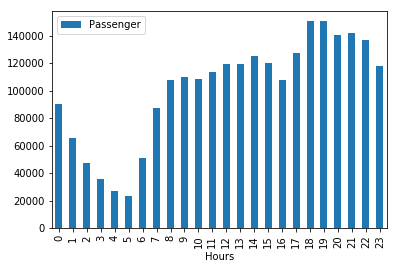

In [20]:
aggr_sum.plot(kind='bar')

(array([ 282627.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,  578159.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

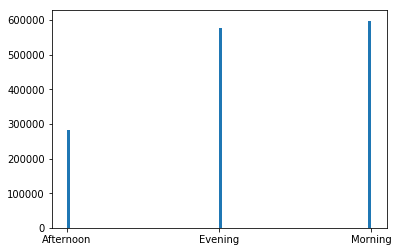

In [21]:
plt.hist(raw_data['dropoff_time'], bins=100)

In [22]:
# play with lon and lat pulak

In [23]:
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [24]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
pickup_Month          1458644 non-null int64
dropoff_Month         1458644 non-null int64
pickup_Hour           1458644 non-null int64
dropoff_Hour          1458644 non-null int64
pickup_season         1458644 non-null object
dropoff_season        1458644 non-null object
pickup_time           1458644 non-null category
dropoff_time          1458644 non-null categ

In [25]:
raw_data['pickup_latitude'][1]

40.738563537597656

In [26]:
print( distance((raw_data['pickup_latitude'][1], raw_data['pickup_longitude'][1]), (raw_data['dropoff_latitude'][1], raw_data['dropoff_longitude'][1])) )

1.8055071687968898


In [27]:
len(raw_data.ix[:])

/Users/neonexxa/machine_learning/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


1458644

In [28]:
# becareful with this part, lame sikit
raw_data['jarak'] = [distance((raw_data['pickup_latitude'][m], raw_data['pickup_longitude'][m]), (raw_data['dropoff_latitude'][m], raw_data['dropoff_longitude'][m])) for m in range(len(raw_data.ix[:]))]

In [29]:
raw_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour,pickup_season,dropoff_season,pickup_time,dropoff_time,jarak
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,3,17,17,spring,spring,Evening,Evening,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,0,0,summer,summer,Morning,Morning,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,11,12,winter,winter,Morning,Morning,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,4,19,19,spring,spring,Evening,Evening,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,3,13,13,spring,spring,Afternoon,Afternoon,1.188588


In [30]:
v = np.array(raw_data['passenger_count'])
w = np.array(raw_data['jarak'])
print(v)

[1 1 1 ..., 1 1 1]


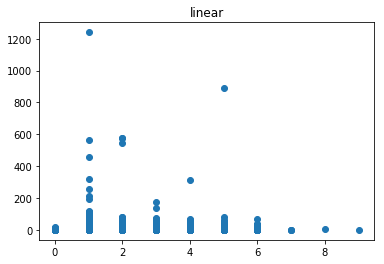

In [31]:
# linear
mpl.rcParams['agg.path.chunksize'] = 10000
plt.scatter(v, w)
plt.yscale('linear')
plt.title('linear')
plt.show()


In [32]:
raw_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour,pickup_season,dropoff_season,pickup_time,dropoff_time,jarak
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,3,17,17,spring,spring,Evening,Evening,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,0,0,summer,summer,Morning,Morning,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,11,12,winter,winter,Morning,Morning,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,4,19,19,spring,spring,Evening,Evening,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,3,13,13,spring,spring,Afternoon,Afternoon,1.188588


In [33]:
raw_data.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour,jarak
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,-0.006221,-0.006201,0.009299,0.009250,0.008109
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,-0.002143,-0.002147,0.009101,0.008449,0.010306
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.004474,0.004517,0.010150,0.010758,0.259780
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,-0.001439,-0.001506,0.010603,0.017043,-0.210354
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,0.004758,0.004795,-0.022455,-0.023361,0.134033
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,-0.000607,-0.000652,0.013612,0.017246,-0.142128
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.006607,0.007512,0.003690,0.002652,0.094777
pickup_Month,-0.006221,-0.002143,0.004474,-0.001439,0.004758,-0.000607,0.006607,1.000000,0.999936,-0.003438,-0.004719,0.015667
dropoff_Month,-0.006201,-0.002147,0.004517,-0.001506,0.004795,-0.000652,0.007512,0.999936,1.000000,-0.003167,-0.005110,0.015839
pickup_Hour,0.009299,0.009101,0.010150,0.010603,-0.022455,0.013612,0.003690,-0.003438,-0.003167,1.000000,0.933977,-0.015813


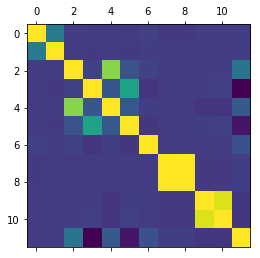

In [34]:
%matplotlib inline
plt.matshow(raw_data.corr())

In [35]:
raw_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour,pickup_season,dropoff_season,pickup_time,dropoff_time,jarak
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,3,17,17,spring,spring,Evening,Evening,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,0,0,summer,summer,Morning,Morning,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,11,12,winter,winter,Morning,Morning,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,4,19,19,spring,spring,Evening,Evening,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,3,13,13,spring,spring,Afternoon,Afternoon,1.188588


In [36]:
# after formatting the date and time, there are few more item i need to remove before begin the prediction as such vendor id and id and the target which is the trip duration
# data prep

X = raw_data.drop(['id','vendor_id','pickup_datetime','dropoff_datetime','store_and_fwd_flag','trip_duration','pickup_season','dropoff_season','pickup_time','dropoff_time'],axis=1)
Y = raw_data["trip_duration"]

X.describe()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [37]:
X_train.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour,jarak
616297,1,-73.954826,40.773689,-73.962044,40.763779,4,4,18,18,1.258509
136774,1,-73.962822,40.772541,-73.984520,40.741158,1,1,11,11,3.939292
1000018,1,-73.950996,40.775043,-73.977310,40.762848,6,6,5,5,2.597981
113392,2,-73.964531,40.758865,-73.954887,40.765175,4,4,9,9,1.073263
1157650,3,-73.863739,40.769981,-73.987564,40.757301,3,3,16,16,10.523442


In [38]:
import pickle

In [39]:
def createmodel(modelalgo,clf):
    # Dump the trained decision tree classifier with Pickle
    model_name = modelalgo+'.pkl'
    # Open the file to save as pkl file
    model_name_pkl = open(model_name, 'wb')
    pickle.dump(clf, model_name_pkl)
    # Close the pickle instances
    model_name_pkl.close()

In [40]:
# begin decision tree regression kat sini

dtrtaxi = tree.DecisionTreeRegressor()
dtrtaxi = dtrtaxi.fit(X_train,y_train)
dtrtaxi_y_pred = dtrtaxi.predict(X_test)
print("Decision Tree Regressor")
print("RMSE: %.4f" %rmse(y_test, dtrtaxi_y_pred))
print("RMSLE: %.4f" %rmsle(y_test, dtrtaxi_y_pred))
print("MAPE: %.4f" %mean_absolute_percentage_error(y_test, dtrtaxi_y_pred))

#pass to create model function
createmodel('dtrtaxi',dtrtaxi)

Decision Tree Regressor
RMSE: 5823.5008
RMSLE: 0.5903
MAPE: 98.2966


In [41]:
from sklearn.ensemble import RandomForestRegressor
rfrtaxi = RandomForestRegressor()
rfrtaxi.fit(X_train, y_train)
rfrtaxi_y_pred = rfrtaxi.predict(X_test)

In [42]:
print("Random Forest Regressor")
print("RMSE: %.4f" %rmse(y_test, rfrtaxi_y_pred))
print("RMSLE: %.4f" %rmsle(y_test, rfrtaxi_y_pred))
print("MAPE: %.4f" %mean_absolute_percentage_error(y_test, rfrtaxi_y_pred))
#pass to create model function
createmodel('rfrtaxi',rfrtaxi)

Random Forest Regressor
RMSE: 5010.2835
RMSLE: 0.5447
MAPE: 81.4006


In [43]:
# check important features
df_importance = pd.DataFrame(X.columns, columns=["Column name"])
df_importance["Feature Importance DTR"] = dtrtaxi.feature_importances_
df_importance["Feature Importance RFR"] = rfrtaxi.feature_importances_
# df_importance.sort_values(["Feature Importance"], ascending=False)
df_importance

,Column name,Feature Importance DTR,Feature Importance RFR
0,passenger_count,0.005767,0.006511
1,pickup_longitude,0.051601,0.062099
2,pickup_latitude,0.054181,0.129048
3,dropoff_longitude,0.057906,0.066234
4,dropoff_latitude,0.050085,0.067765
5,pickup_Month,0.006088,0.017136
6,dropoff_Month,0.008544,0.028772
7,pickup_Hour,0.462302,0.312152
8,dropoff_Hour,0.017837,0.084308
9,jarak,0.285690,0.225974


In [44]:
from sklearn import preprocessing
NewX = raw_data.drop(['id','vendor_id','pickup_datetime','dropoff_datetime','trip_duration'],axis=1)
NewY = raw_data["trip_duration"]

# encode data prep
le_flag = preprocessing.LabelEncoder()
NewX["store_and_fwd_flag"] = le_flag.fit_transform(NewX["store_and_fwd_flag"])

le_pseason = preprocessing.LabelEncoder()
NewX["pickup_season"] = le_pseason.fit_transform(NewX["pickup_season"])

le_dseason = preprocessing.LabelEncoder()
NewX["dropoff_season"] = le_dseason.fit_transform(NewX["dropoff_season"])

le_ptime = preprocessing.LabelEncoder()
NewX["pickup_time"] = le_ptime.fit_transform(NewX["pickup_time"])

le_dtime = preprocessing.LabelEncoder()
NewX["dropoff_time"] = le_dtime.fit_transform(NewX["dropoff_time"])


In [45]:
NewX

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_Month,dropoff_Month,pickup_Hour,dropoff_Hour,pickup_season,dropoff_season,pickup_time,dropoff_time,jarak
0,1,-73.982155,40.767937,-73.964630,40.765602,0,3,3,17,17,0,0,1,1,1.498521
1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,6,0,0,1,1,2,2,1.805507
2,1,-73.979027,40.763939,-74.005333,40.710087,0,1,1,11,12,2,2,2,2,6.385098
3,1,-74.010040,40.719971,-74.012268,40.706718,0,4,4,19,19,0,0,1,1,1.485498
4,1,-73.973053,40.793209,-73.972923,40.782520,0,3,3,13,13,0,0,0,0,1.188588
5,6,-73.982857,40.742195,-73.992081,40.749184,0,1,1,22,22,2,2,1,1,1.098942
6,4,-73.969017,40.757839,-73.957405,40.765896,0,6,6,22,22,1,1,1,1,1.326279
7,1,-73.969276,40.797779,-73.922470,40.760559,0,5,5,7,8,0,0,2,2,5.714981
8,1,-73.999481,40.738400,-73.985786,40.732815,0,5,5,23,23,0,0,1,1,1.310353
9,1,-73.981049,40.744339,-73.973000,40.789989,0,3,3,21,22,0,0,1,1,5.121162


In [46]:
NewX_train, NewX_test, Newy_train, Newy_test = train_test_split(NewX, NewY, test_size=0.05, random_state=1)

In [47]:
# begin decision tree regression kat sini for NewX and NewY

Newdtrtaxi = tree.DecisionTreeRegressor()
Newdtrtaxi = Newdtrtaxi.fit(NewX_train,Newy_train)
Newdtrtaxi_y_pred = Newdtrtaxi.predict(NewX_test)
print("Decision Tree Regressor")
print("RMSE: %.4f" %rmse(Newy_test, Newdtrtaxi_y_pred))
print("RMSLE: %.4f" %rmsle(Newy_test, Newdtrtaxi_y_pred))
print("MAPE: %.4f" %mean_absolute_percentage_error(Newy_test, Newdtrtaxi_y_pred))

#pass to create model function
createmodel('Newdtrtaxi',Newdtrtaxi)

Decision Tree Regressor
RMSE: 8747.3802
RMSLE: 0.5864
MAPE: 73.9763


In [48]:
Newrfrtaxi = RandomForestRegressor()
Newrfrtaxi.fit(NewX_train, Newy_train)
Newrfrtaxi_y_pred = Newrfrtaxi.predict(NewX_test)
print("Random Forest Regressor")
print("RMSE: %.4f" %rmse(Newy_test, Newrfrtaxi_y_pred))
print("RMSLE: %.4f" %rmsle(Newy_test, Newrfrtaxi_y_pred))
print("MAPE: %.4f" %mean_absolute_percentage_error(Newy_test, Newrfrtaxi_y_pred))
#pass to create model function
createmodel('Newrfrtaxi',Newrfrtaxi)

Random Forest Regressor
RMSE: 8216.3546
RMSLE: 0.5438
MAPE: 66.5432


In [49]:
from sklearn.ensemble import GradientBoostingRegressor
Newgbrtaxi = RandomForestRegressor()
Newgbrtaxi.fit(NewX_train, Newy_train)
Newgbrtaxi_y_pred = Newgbrtaxi.predict(NewX_test)
print("Gradient Boosting Regressor")
print("RMSE: %.4f" %rmse(Newy_test, Newgbrtaxi_y_pred))
print("RMSLE: %.4f" %rmsle(Newy_test, Newgbrtaxi_y_pred))
print("MAPE: %.4f" %mean_absolute_percentage_error(Newy_test, Newgbrtaxi_y_pred))
#pass to create model function
createmodel('Newgbrtaxi',Newgbrtaxi)

Gradient Boosting Regressor
RMSE: 8194.3547
RMSLE: 0.5378
MAPE: 69.0995


In [50]:
# regen model since the features in the test set does not have dropoff datetime column
RegenX = raw_data.drop(['id','vendor_id','pickup_datetime','dropoff_datetime','dropoff_Month','dropoff_Hour','dropoff_season','dropoff_time','trip_duration'],axis=1)
RegenY = raw_data["trip_duration"]

# encode data prep
le_flag = preprocessing.LabelEncoder()
RegenX["store_and_fwd_flag"] = le_flag.fit_transform(RegenX["store_and_fwd_flag"])

le_pseason = preprocessing.LabelEncoder()
RegenX["pickup_season"] = le_pseason.fit_transform(RegenX["pickup_season"])

# le_dseason = preprocessing.LabelEncoder()
# NewX["dropoff_season"] = le_dseason.fit_transform(NewX["dropoff_season"])

le_ptime = preprocessing.LabelEncoder()
RegenX["pickup_time"] = le_ptime.fit_transform(RegenX["pickup_time"])

# le_dtime = preprocessing.LabelEncoder()
# NewX["dropoff_time"] = le_dtime.fit_transform(NewX["dropoff_time"])

RegenX

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_Month,pickup_Hour,pickup_season,pickup_time,jarak
0,1,-73.982155,40.767937,-73.964630,40.765602,0,3,17,0,1,1.498521
1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,0,1,2,1.805507
2,1,-73.979027,40.763939,-74.005333,40.710087,0,1,11,2,2,6.385098
3,1,-74.010040,40.719971,-74.012268,40.706718,0,4,19,0,1,1.485498
4,1,-73.973053,40.793209,-73.972923,40.782520,0,3,13,0,0,1.188588
5,6,-73.982857,40.742195,-73.992081,40.749184,0,1,22,2,1,1.098942
6,4,-73.969017,40.757839,-73.957405,40.765896,0,6,22,1,1,1.326279
7,1,-73.969276,40.797779,-73.922470,40.760559,0,5,7,0,2,5.714981
8,1,-73.999481,40.738400,-73.985786,40.732815,0,5,23,0,1,1.310353
9,1,-73.981049,40.744339,-73.973000,40.789989,0,3,21,0,1,5.121162


In [51]:
# new split data
RegenX_train, RegenX_test, Regeny_train, Regeny_test = train_test_split(RegenX, RegenY, test_size=0.05, random_state=1)

# rerun with gboostReg
Regengbrtaxi = RandomForestRegressor()
Regengbrtaxi.fit(RegenX_train, Regeny_train)

ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 11 

In [52]:
Regengbrtaxi_y_pred = Regengbrtaxi.predict(RegenX_test)
print("Gradient Boosting Regressor")
print("RMSE: %.4f" %rmse(Regeny_test, Regengbrtaxi_y_pred))
print("RMSLE: %.4f" %rmsle(Regeny_test, Regengbrtaxi_y_pred))
print("MAPE: %.4f" %mean_absolute_percentage_error(Regeny_test, Regengbrtaxi_y_pred))
#pass to create model function
createmodel('Regengbrtaxi',Regengbrtaxi)

Gradient Boosting Regressor
RMSE: 8302.9213
RMSLE: 0.5561
MAPE: 76.7121
